<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_using_YOLO_v10_and_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)

## 0. Setting for Google Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install ultralytics
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [6]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [7]:
files = os.listdir('./axial_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00270_11


In [8]:
with open(os.path.join('./axial_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(512, 448, 3)


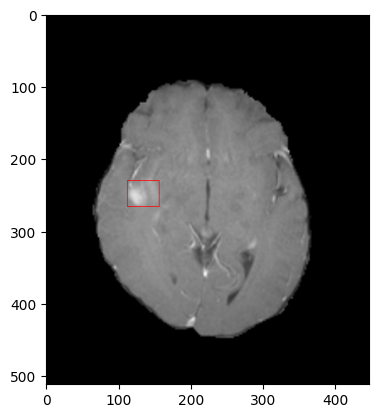

In [9]:
img = cv2.imread(os.path.join('./axial_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [10]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [11]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./axial_t1wce_2_class/images/train', image))

In [12]:
train_images = os.listdir('./axial_t1wce_2_class/images/train')
test_images = os.listdir('./axial_t1wce_2_class/images/test')
train_labels = os.listdir('./axial_t1wce_2_class/labels/train')
test_labels = os.listdir('./axial_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [13]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./axial_t1wce_2_class/images/val'):
    shutil.rmtree('./axial_t1wce_2_class/images/val')
if os.path.exists('./axial_t1wce_2_class/labels/val'):
    shutil.rmtree('./axial_t1wce_2_class/labels/val')

os.mkdir('././axial_t1wce_2_class/images/val')
os.mkdir('././axial_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./axial_t1wce_2_class/images/train', image), './axial_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./axial_t1wce_2_class/labels/train', label), './axial_t1wce_2_class/labels/val')

In [14]:
text ="""
path: ../axial_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [15]:
model = YOLO('yolov10s.pt')

100%|██████████| 15.9M/15.9M [00:00<00:00, 216MB/s]


In [16]:
results = model.train(data='./fixed_path.yaml', batch=-1, epochs=50, device=0)

Ultralytics YOLOv8.2.62 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10s.pt, data=./fixed_path.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 207MB/s]


AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.25G reserved, 0.10G allocated, 14.39G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     8067900       24.77         0.682         44.38           nan        (1, 3, 640, 640)                    list
     8067900       49.55         1.267         34.13           nan        (2, 3, 640, 640)                    list
     8067900        99.1         2.462         41.22           nan        (4, 3, 640, 640)                    list
     8067900       198.2         4.706         59.86           nan        (8, 3, 640, 640)                    list
     8067900       396.4         9.091         94.53           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 15 for CUDA:0 8.92G/14.75G (60%) ✅


train: Scanning /content/axial_t1wce_2_class/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 2046.52it/s]

train: New cache created: /content/axial_t1wce_2_class/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/axial_t1wce_2_class/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1606.16it/s]

val: New cache created: /content/axial_t1wce_2_class/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.00046875), 111 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.26G      3.479      34.16      3.049         15        640: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         59         59      0.532     0.0588     0.0137    0.00947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.23G      2.531      12.32      2.309         25        640: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         59         59      0.532     0.0588     0.0137    0.00947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.24G      2.472      5.839      2.256         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         59         59      0.137      0.144     0.0486     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.24G      2.694      4.259      2.331         26        640: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         59         59      0.549       0.27      0.153     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.24G      2.682      4.187      2.369         13        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         59         59   0.000678      0.192   0.000423   0.000115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.24G      2.651      3.407      2.398         26        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         59         59     0.0653      0.159     0.0176    0.00639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.24G      2.746      3.209      2.412         21        640: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         59         59      0.159     0.0347    0.00944    0.00461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.24G      2.674      3.094      2.394         22        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         59         59      0.117      0.366     0.0993     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.24G      2.516       2.87      2.293         13        640: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         59         59     0.0181      0.232    0.00677    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.24G      2.624      2.916      2.428         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         59         59      0.171      0.523      0.195      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.24G      2.465      2.764      2.291         29        640: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         59         59      0.338      0.446       0.39      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.24G      2.498       2.62      2.294         16        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         59         59      0.734      0.269      0.315       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.24G      2.519      2.523      2.324         17        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         59         59      0.427      0.453      0.412      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.24G      2.429      2.364      2.202         19        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

                   all         59         59       0.63      0.486      0.488      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.24G      2.372      2.201      2.215         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         59         59      0.523      0.797       0.67      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.24G        2.4       2.26      2.236         11        640: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         59         59      0.819      0.626      0.763      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.23G      2.361       2.26      2.238         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         59         59       0.76      0.551      0.604      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.23G      2.285      2.222      2.238         20        640: 100%|██████████| 16/16 [00:07<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         59         59      0.521      0.612      0.653      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.24G      2.232       2.33      2.173         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         59         59       0.58      0.701      0.651      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.24G      2.271      2.167      2.184         20        640: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         59         59      0.736      0.752      0.773      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.23G      2.208      2.059       2.19         30        640: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59         59      0.586      0.741       0.77      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.23G      2.314      2.151      2.261         25        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         59         59      0.606      0.666      0.667      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.24G      2.124      1.984      2.158         25        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         59         59      0.602      0.709      0.695      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.23G       2.08      1.956      2.129         18        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         59         59       0.71      0.727      0.769      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.24G      2.186      2.076      2.178         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         59         59      0.777      0.573      0.713      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.24G      2.085      1.686      2.108         21        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         59         59      0.668      0.736      0.824      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.23G      2.031      1.677      2.076         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         59         59      0.609      0.712      0.722       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.24G       2.11      1.686      2.038         24        640: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         59         59      0.578      0.704      0.679      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.24G      1.994      1.649      2.066         15        640: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         59         59      0.694      0.767       0.82      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.23G      2.112      1.631      2.134         21        640: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         59         59      0.809      0.641      0.756      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.23G      1.973      1.606      2.044         29        640: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         59         59      0.785       0.66      0.772      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.23G      1.917      1.521      1.992         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         59         59      0.782      0.705      0.799      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.24G      1.963       1.61      2.101         14        640: 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         59         59       0.66      0.779      0.773      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.24G      2.007      1.657      2.074         31        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         59         59      0.711       0.75      0.771       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.24G      1.959       1.42      2.037         23        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         59         59      0.502      0.677       0.66      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.23G      1.842      1.306      1.988         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         59         59       0.69       0.79      0.798      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.23G      1.804      1.386      2.018         18        640: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         59         59      0.659      0.737      0.769      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.23G      1.819      1.213      1.967         28        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         59         59      0.727      0.608      0.705      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.24G      1.808      1.282      1.983         20        640: 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         59         59      0.676      0.876      0.807      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.24G      1.769      1.326      1.973         26        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         59         59      0.782      0.803       0.84      0.594


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.24G      1.681      1.151      1.984         14        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         59         59      0.762      0.772      0.802       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.24G      1.578      1.115      1.927         13        640: 100%|██████████| 16/16 [00:08<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         59         59      0.776      0.828      0.883      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.23G      1.607      1.001      1.929         12        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         59         59      0.857       0.71       0.88      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.23G      1.528      1.025      1.884         12        640: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         59         59       0.77       0.83      0.859      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.23G      1.553      1.011      1.935         14        640: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         59         59      0.748      0.901      0.891      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.23G      1.528     0.8833      1.871         12        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         59         59      0.866      0.846      0.911      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.23G      1.517     0.8734      1.918         13        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         59         59      0.854      0.853      0.895      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.23G      1.434     0.8383      1.868         13        640: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         59         59      0.858      0.869      0.904      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.23G      1.502     0.8386      1.875         14        640: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         59         59      0.907      0.852      0.913       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.23G      1.479     0.8065      1.882         12        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         59         59      0.896      0.848       0.91      0.663



50 epochs completed in 0.135 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 16.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 16.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.62 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10s summary (fused): 293 layers, 8,036,508 parameters, 0 gradients, 24.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


                   all         59         59      0.895      0.849       0.91      0.663
              negative         25         25      0.826       0.88      0.875      0.632
              positive         34         34      0.965      0.817      0.945      0.695
Speed: 0.3ms preprocess, 6.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/train


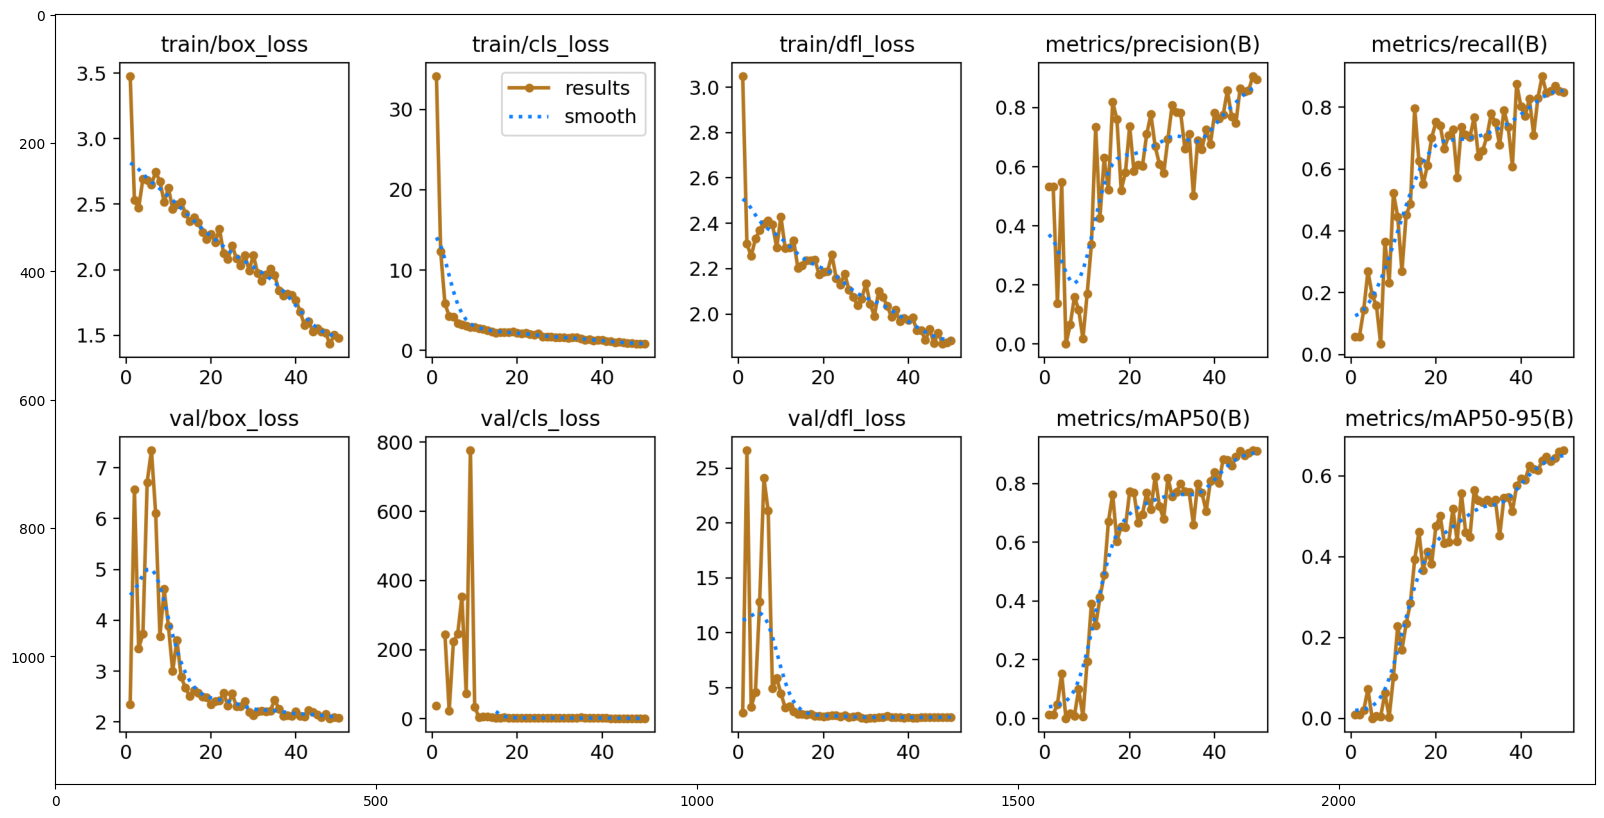

In [17]:
training_save_dir = './' + str(results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

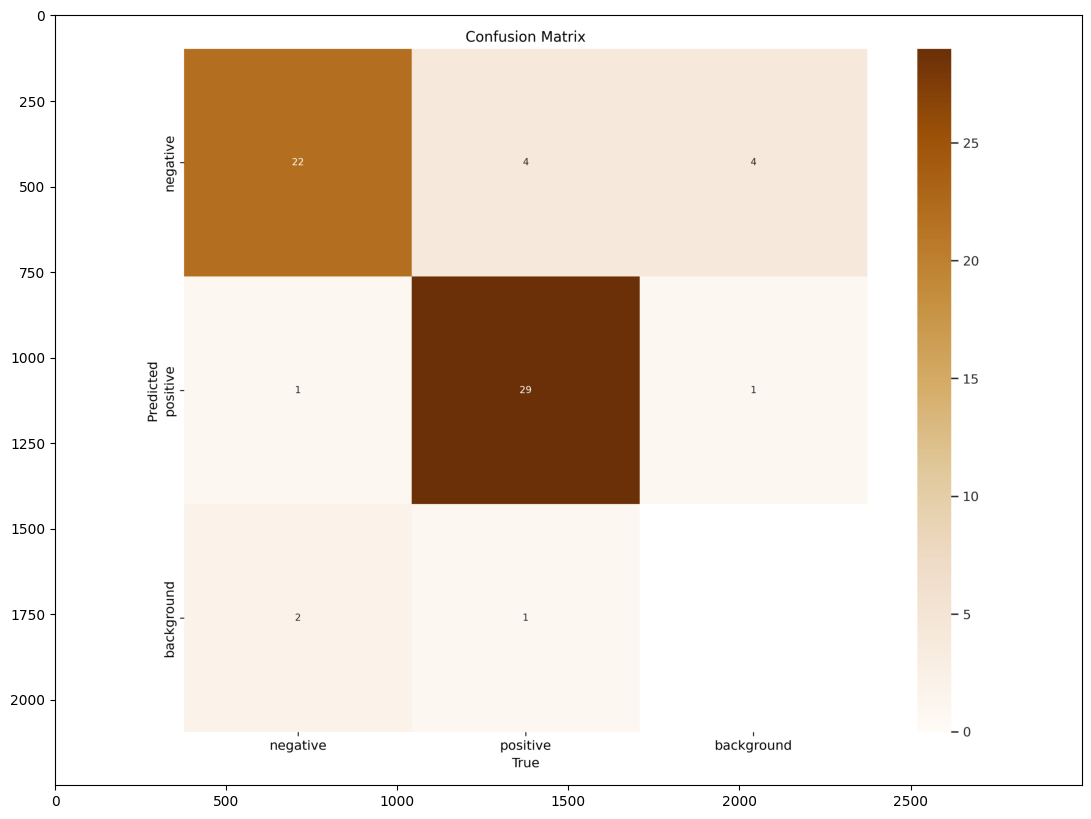

In [18]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

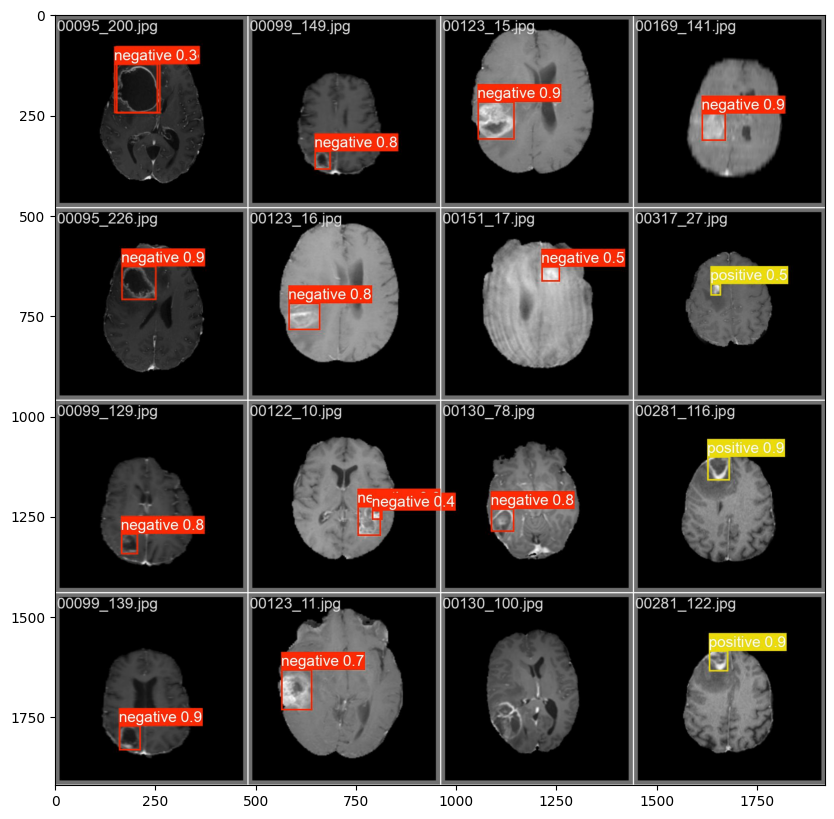

In [19]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

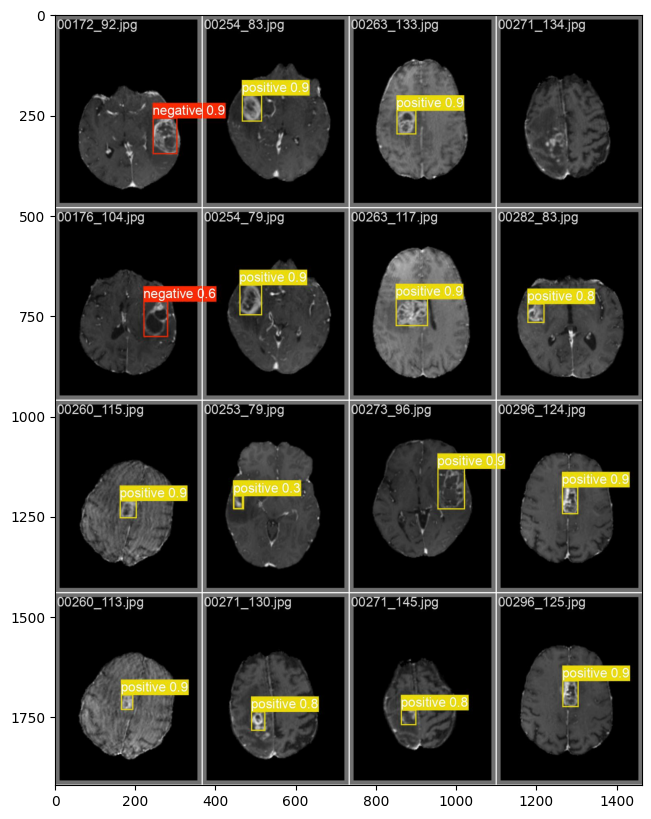

In [20]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [21]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="./axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /content/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 (no detections), 28.9ms
image 2/75 /content/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 23.7ms
image 3/75 /content/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 19.7ms
image 4/75 /content/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 (no detections), 17.4ms
image 5/75 /content/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 15.8ms
image 6/75 /content/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 15.5ms
image 7/75 /content/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 15.5ms
image 8/75 /content/axial_t1wce_2_class/images/test/00019_66.jpg: 640x640 1 negative, 15.5ms
image 9/75 /content/axial_t1wce_2_class/images/test/00019_75.jpg: 640x640 1 negative, 1 positive, 15.4ms
image 10/75 /content/axial_t1wce_2_class/images/test/00019_84.jpg: 640x640 (no detections), 15.5ms
image 11/75 /content/axial_t1

In [22]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [23]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.362844', '0.607463', '0.114407', '0.128319', '0.500596\n']
['0', '0.363850', '0.606808', '0.107981', '0.129108']


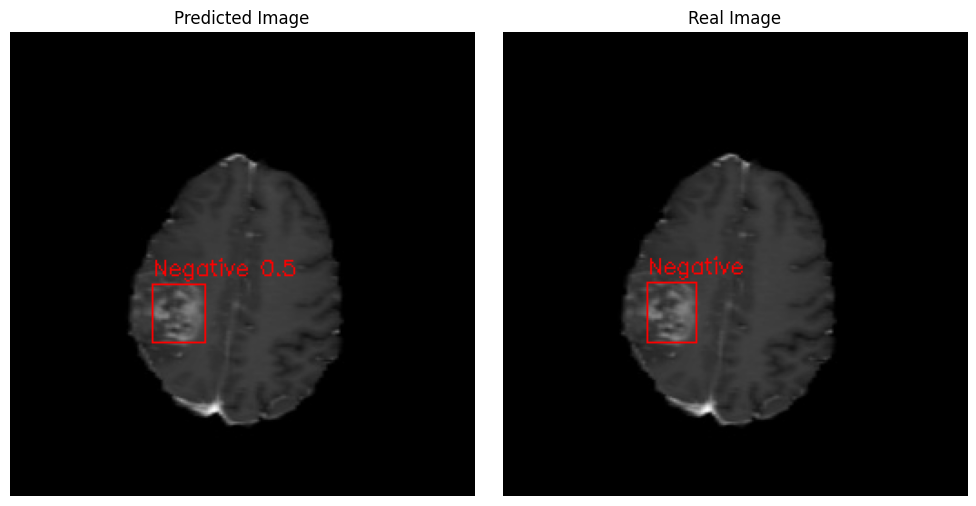

In [24]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./axial_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [25]:
text = """
path: ../axial_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [26]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.62 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/axial_t1wce_2_class/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 1966.17it/s]

val: New cache created: /content/axial_t1wce_2_class/labels/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


                   all         75         81      0.809      0.753      0.818       0.61
              negative         75         81      0.809      0.753      0.818       0.61
Speed: 0.8ms preprocess, 17.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


In [27]:
test_save_dir = './' + str(metrics.save_dir)

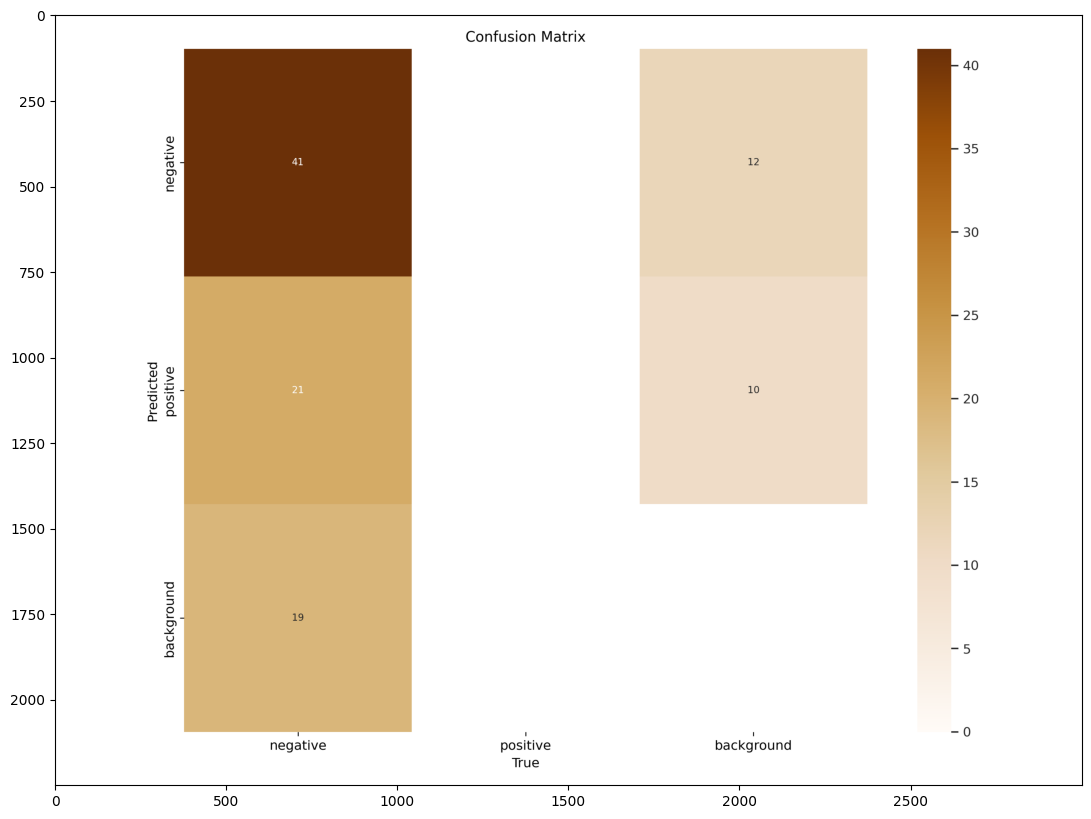

In [28]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

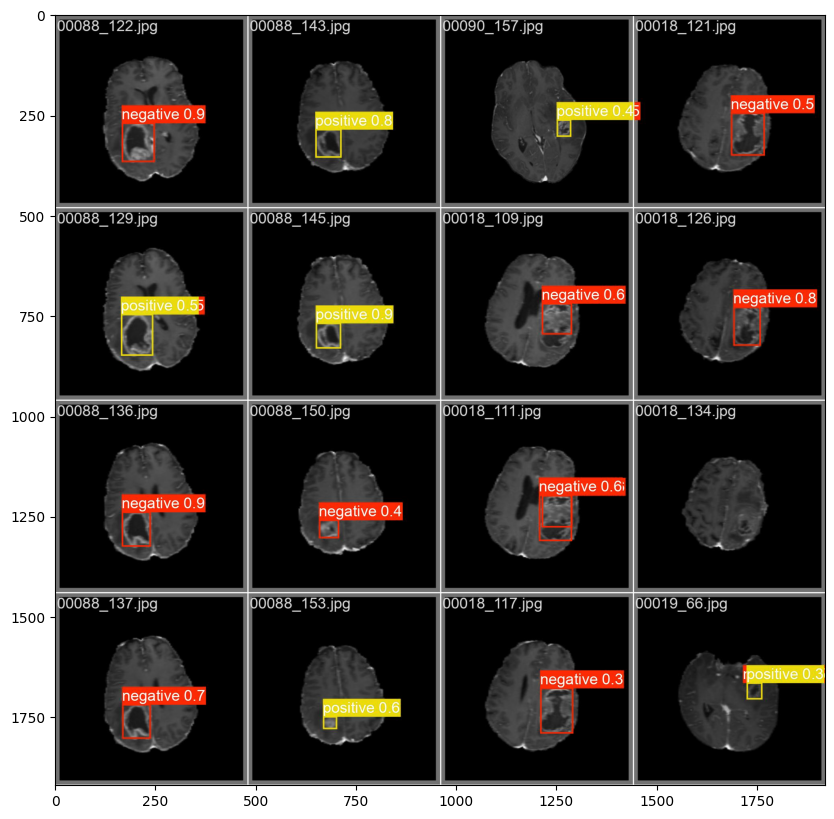

In [29]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

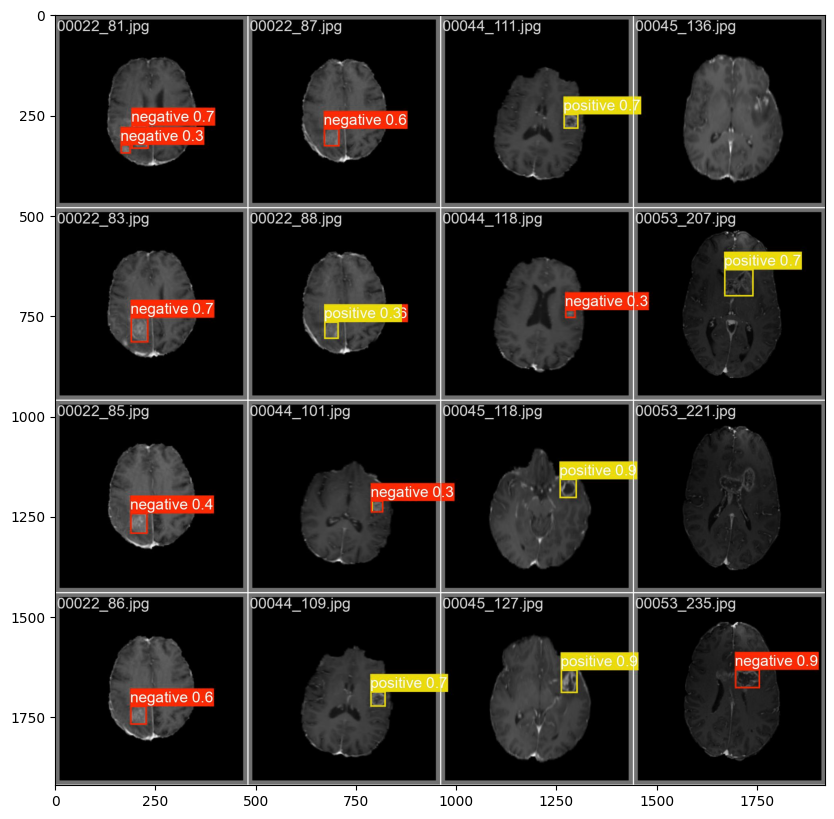

In [30]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

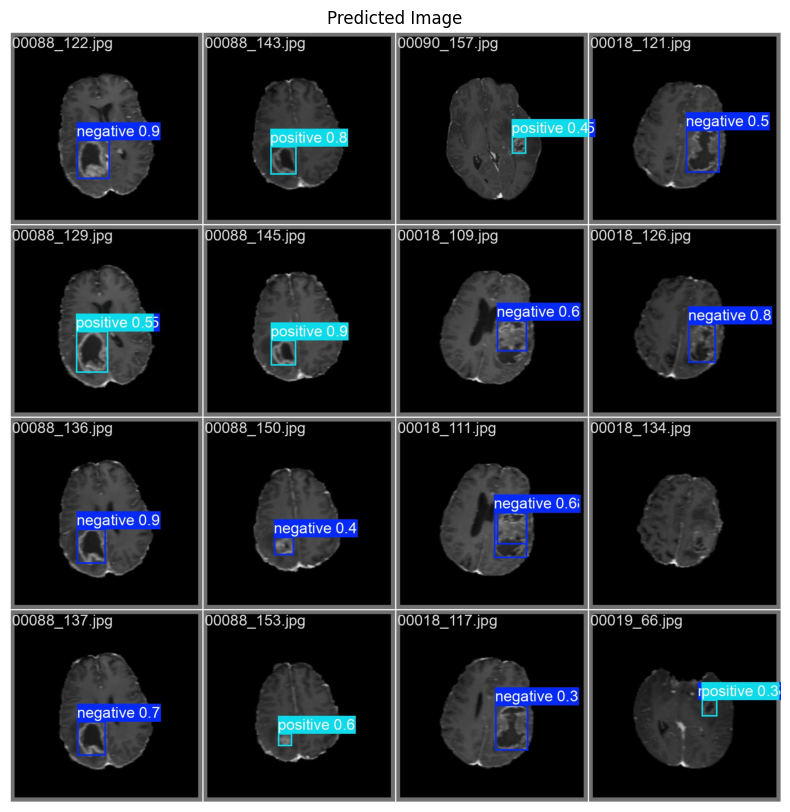

In [31]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [44]:
real_path = os.path.join('./axial_t1wce_2_class/images/test', f'{random_file}.jpg')

In [45]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [46]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pxaa5tp9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pxaa5tp9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=0b0d2ed0433d58578657e4b16052aea5813c202b7a201bb258ad5add30969320
  Stored in directory: /tmp/pip-ephem-wheel-cache-uj_h8gxg/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [47]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2024-07-22 04:57:49--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.133.4, 108.156.133.117, 108.156.133.64, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.133.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  31.7MB/s    in 42s     

2024-07-22 04:58:31 (58.9 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [49]:
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(img_pred)

In [50]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [51]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]


image 1/1 /content/axial_t1wce_2_class/images/test/00084_156.jpg: 640x640 1 negative, 1 positive, 17.5ms
Speed: 55.5ms preprocess, 17.5ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)


In [52]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:199: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  y_embed = grid.cumsum(dim=0) - 0.5
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/prompt_encoder.py:200: UserWarning: cumsum_cuda_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)
  x_embed = grid.cumsum(dim=1) - 0.5


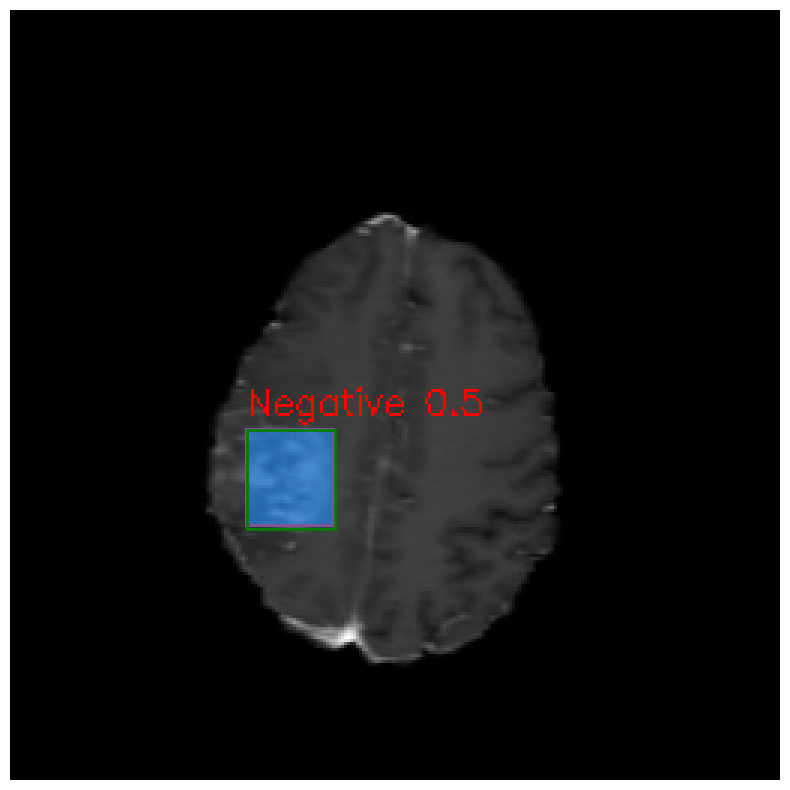

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(img_pred, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()